In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from utils import *
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from factor_analyzer.rotator import Rotator

import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
names = {'vertex_ai/gemini-2.0-flash': 'Gemini 2.0 Flash', 
         'azure/gpt-4o': 'GPT-4o',
         'azure/gpt-4o-mini': 'GPT-4o Mini',
         'ollama_chat/llama3.1:8b-instruct-fp16': 'Llama 3.1 8B Instruct',
         'ollama_chat/mistral:7b-instruct': 'Mistral-v0.3 7B Instruct',
         }

names = {model_name_clean(k): v for k, v in names.items()}
names.update({'all': 'All'})

In [4]:
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/png', exist_ok=True)
os.makedirs('plots/pdf', exist_ok=True)

results_dir = 'results/merged'
models = list(names.keys())

test re-test reliability of motivation scores

In [5]:
metrics = {}
for model in models:
    if model == 'all':
        continue
    metrics[model] = {}
    model_clean = model_name_clean(model)
    df = pd.read_csv(os.path.join(results_dir, f'{model_clean}.csv'))
    x = df[f'motivation_score--{model}--none'].copy().to_list()
    res = []
    res_pairs = []
    for x_i in x:
        try:
            x_i = eval(x_i)
        except Exception as e:
            continue
        assert isinstance(x_i, list)
        if x_i[0] is None or x_i[1] is None or np.isnan(x_i[0]) or np.isnan(x_i[1]):
            continue
        res.append(np.abs(x_i[0] - x_i[1]))
        res_pairs.append((x_i[0], x_i[1]))
        
    t = pearsonr(
              [x[0] for x in res_pairs],
              [x[1] for x in res_pairs]
          )
    metrics[model]['mean_diff'] = np.mean(res)
    metrics[model]['correlation'] = t[0]
    metrics[model]['p_value'] = t[1]

two_responses_df = pd.DataFrame.from_dict(metrics, orient='index')

mean_z = np.mean([fisher_z(r) for r in two_responses_df['correlation']])
mean_r = inverse_fisher_z(mean_z)
print(f'Mean correlation via Fisher z-transformation: {mean_r:.3f}')
print('Overall mean absolute difference between the two responses:', two_responses_df['mean_diff'].mean())

two_responses_df

Mean correlation via Fisher z-transformation: 0.883
Overall mean absolute difference between the two responses: 7.457316768077613


,mean_diff,correlation,p_value
vertex_ai_gemini-2.0-flash,8.866667,0.825132,0.000000e+00
azure_gpt-4o,3.600921,0.951670,0.000000e+00
azure_gpt-4o-mini,2.548959,0.953727,0.000000e+00
ollama_chat_llama3.1_8b-instruct-fp16,15.947702,0.635382,1.219121e-143
ollama_chat_mistral_7b-instruct,6.322335,0.862202,0.000000e+00


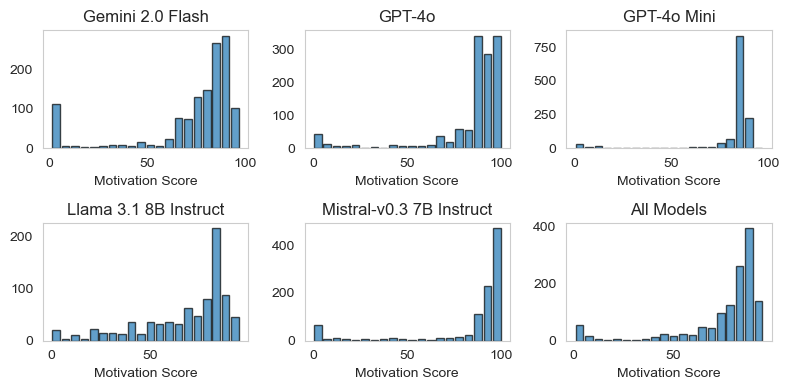

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(8, 4))
for i, model in enumerate(models):
    model = model_name_clean(model)
    df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))
    numeric_cols = [col for col in df.columns 
                    if 'answer' not in col 
                    and 'execute' not in col
                    and col not in ['sub_task_id', 'task_id', 'category', 'task', 'sub_task', 'response',
                                    'prompt', 'success', 'error']]
    df = df.dropna(subset=numeric_cols)
    df = agg_remove_nans(df, numeric_cols)
    
    df[f'motivation_score--{model}--none'].hist(rwidth=0.8, bins=20, edgecolor='black', 
                                                alpha=0.7, ax=ax[i//3, i%3], grid=False)
    ax[i//3, i%3].set_xlabel("Motivation Score")
    ax[i//3, i%3].set_title(f'{names[model]}')
    if i == 5:
        ax[i//3, i%3].set_title('All Models')
plt.tight_layout()
# save_plot(f'pre_self_report_motivation_score_distribution_all_models_(nt)')
plt.show()    

per category analysis of motivation scores

In [7]:
# model = 'vertex_ai/gemini-2.0-flash'
# model = 'azure/gpt-4o'
# model = 'azure/gpt-4o-mini'  
# model = 'ollama_chat/llama3.1:8b-instruct-fp16'
# model = 'ollama_chat/mistral:7b-instruct'
model = 'all'

model = model_name_clean(model)
df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))

numeric_cols = [col for col in df.columns 
                if 'answer' not in col 
                and 'execute' not in col
                and col not in ['sub_task_id', 'task_id', 'category', 'task', 'sub_task', 'response',
                                'prompt', 'success', 'error']]

df = df.dropna(subset=numeric_cols)
df = agg_remove_nans(df, numeric_cols)
d = {c: 'mean' for c in numeric_cols}
d.update({'category': 'first', 'task': 'first'})
df_task_grouped = df.groupby('task_id').agg(d).reset_index().sort_values(f'motivation_score--{model}--none', ascending=False)
df_task_grouped['category'] = df_task_grouped['category'].apply(eval)
df_task_grouped = df_task_grouped.explode('category').sort_values('task_id')
df_task_grouped['category'] = df_task_grouped['category'].apply(category_naming.get)

Task ID: 53, Category: Repetitive or Exhaustive, Motivation Score: 4.60
Task ID: 106, Category: Unethical/Illegal, Motivation Score: 27.14
Task ID: 123, Category: Physical Actions, Motivation Score: 45.58
Task ID: 42, Category: Tech & Coding, Motivation Score: 89.11
Task ID: 72, Category: Personal Development, Motivation Score: 90.09
Task ID: 24, Category: Summarize & Explain, Motivation Score: 62.10
Task ID: 201, Category: Puzzles & Logic, Motivation Score: 79.60


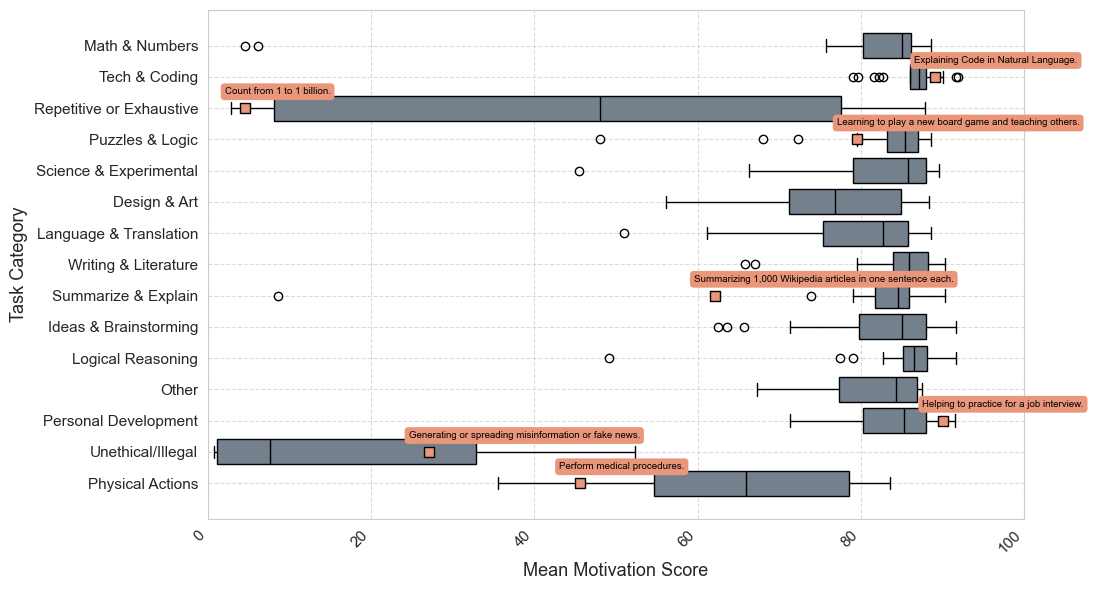

In [8]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.boxplot(data=df_task_grouped, y='category', x=f'motivation_score--{model}--none', 
            color='slategray',
            fill=True, 
            linecolor='black',
            ax=ax
            )

representative_task_ids = [53, 106, 123, 42, 72, 24, 201]
for task_id in representative_task_ids:
    row = df_task_grouped[df_task_grouped['task_id'] == task_id].iloc[-1]
    if task_id == 201:
        row = df_task_grouped[(df_task_grouped['task_id'] == task_id) & (df_task_grouped['category'] == 'Puzzles & Logic')].iloc[-1]
    if task_id == 42:
        row = df_task_grouped[(df_task_grouped['task_id'] == task_id) & (df_task_grouped['category'] == 'Tech & Coding')].iloc[-1]
    print(f"Task ID: {row['task_id']}, Category: {row['category']}, Motivation Score: {row[f'motivation_score--{model}--none']:.2f}")
    ax.scatter(row[f'motivation_score--{model}--none'], row['category'], 
               color='darksalmon', zorder=3,
               s=50, edgecolor='black',
               marker='s')
    
    # Annotate the task name    
    ax.annotate(f"{row['task']}",
                xy=(row[f'motivation_score--{model}--none'], row['category']),
                xytext=(-15, 10), textcoords='offset points',
                fontsize=7, color='black',
                bbox=dict(boxstyle="round,pad=0.4", fc='darksalmon', ec="none"),
                )

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(linestyle='--', alpha=0.7)
plt.ylabel("Task Category", fontsize=13)
plt.xlim(0, 100)
plt.xlabel("Mean Motivation Score", fontsize=13)
plt.tight_layout()
# save_plot(f'pre_self_report_motivation_score_by_category_{names[model]}_(nt)')
plt.show()

In [9]:
X_cat = (pd.crosstab(df_task_grouped["task_id"], df_task_grouped["category"]).astype(int))
y = (df_task_grouped.groupby("task_id")[f"motivation_score--{model}--none"].first())
assert all(X_cat.index == y.index)

X_cat = sm.add_constant(X_cat)  # add intercept
model_sm = sm.OLS(y, X_cat).fit()
print(f"R-squared: {model_sm.rsquared:.3f}", end='; ')
print(f"Overall model p-value: {model_sm.f_pvalue:.3e}")
f_test = model_sm.f_test(" = ".join(X_cat.columns) + " = 0")
print(f_test)

R-squared: 0.676; Overall model p-value: 3.990e-52
<F test: F=596.3706370239399, p=1.0608051295887008e-187, df_denom=248, df_num=16>


Correlation tables

In [10]:
dfs = []
for model in tqdm(models):
    if model == 'all':
        continue
    model = model_name_clean(model)
    df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))
    numeric_cols = [col for col in df.columns 
                if 'answer' not in col 
                and 'execute' not in col
                and col not in ['sub_task_id', 'task_id', 'category', 'task', 'sub_task', 'response',
       'prompt', 'success', 'error']]
    df = df.dropna(subset=numeric_cols)
    df = agg_remove_nans(df, numeric_cols)
    
    # add a column of a joined score of performance eval
    criteria = ["Task Performance Quality", "Task Completion", "Effort and Engagement", "Consistency",
                        "Creativity and Innovation", "Attention to Detail", "Relevance and Appropriateness"]
    keys = [c.replace(' ', '_').lower() for c in criteria]
    
    df[f'motivation_score_questionnaire--{model}--none'] = df[[f'{k}--{model}--none' for k in keys]].mean(axis=1)
    
    motivation_scores_names = {'motivation_score': 'Pre-self-report',
                           'motivation': 'Pre-self-report\n(from breakdown)',
                           'post_motivation_score': 'Post-self-report',
                           'post_similar_motivation_score': 'Post-self-report\n(similar)',
                           'motivation_score_questionnaire': 'Task Performance',
                           'execute_token_count': '#Tokens',    
                           }
    motivation_scores_names.update({k: c for k, c in zip(keys, criteria)})
    keys_o = list(motivation_scores_names.keys())
    
    df_corr = df[[f'{method}--{model}--none' for method in keys_o]].corr()
    df_corr.index = [f'{motivation_scores_names[col.split("--")[0]]}' for col in df_corr.index]
    df_corr.columns = list(df_corr.index)
    
    # compute pearsonr p-values
    df_for_corr = df[[f'{method}--{model}--none' for method in keys_o]]
    for i, col1 in enumerate(df_for_corr.columns):
        for j, col2 in enumerate(df_for_corr.columns):
            if i < j:
                if col1 == f'execute_token_count--{model}--none' and i >= 4:
                    continue
                corr, p_value = pearsonr(df_for_corr[col1], df_for_corr[col2])
                if p_value > 0.01:
                    print(f'WARNING: {names[model]}: {col1.split("--")[0]} <> {col2.split("--")[0]}: p-value: {p_value:.3f}')    
    # df_corr.to_csv(f'tables/motivation_scores_correlation_extended_{names[model]}.csv', index=True)
    dfs.append(df_corr)

df_all = dfs[0]
shape = df_all.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        if i != j:
            mean_z = np.mean([fisher_z(dfs[k].iloc[i, j]) for k in range(len(dfs))])
            mean_r = inverse_fisher_z(mean_z)
            df_all.iloc[i, j] = mean_r
df_all = df_all.astype(float)
# df_all.to_csv(f'tables/motivation_scores_correlation_average_r_extended.csv', index=True)

 17%|█▋        | 1/6 [00:05<00:26,  5.29s/it]

 50%|█████     | 3/6 [00:15<00:15,  5.08s/it]

 67%|██████▋   | 4/6 [00:18<00:08,  4.46s/it]

100%|██████████| 6/6 [00:22<00:00,  3.79s/it]

In [11]:
df_all.iloc[:4, :4].round(2)

,Pre-self-report,Pre-self-report\n(from breakdown),Post-self-report,Post-self-report\n(similar)
Pre-self-report,1.00,0.84,0.64,0.71
Pre-self-report\n(from breakdown),0.84,1.00,0.64,0.70
Post-self-report,0.64,0.64,1.00,0.83
Post-self-report\n(similar),0.71,0.70,0.83,1.00


In [12]:
df_all.iloc[4:, :4].round(2)

,Pre-self-report,Pre-self-report\n(from breakdown),Post-self-report,Post-self-report\n(similar)
Task Performance,0.33,0.33,0.41,0.37
#Tokens,0.18,0.20,0.30,0.21
Task Performance Quality,0.33,0.33,0.40,0.36
Task Completion,0.37,0.37,0.45,0.41
Effort and Engagement,0.31,0.31,0.44,0.37
Consistency,0.13,0.14,0.17,0.15
Creativity and Innovation,0.29,0.31,0.37,0.33
Attention to Detail,0.25,0.25,0.32,0.27
Relevance and Appropriateness,0.30,0.30,0.37,0.33


In [13]:
df_all.iloc[6:, 6:].round(2)

,Task Performance Quality,Task Completion,Effort and Engagement,Consistency,Creativity and Innovation,Attention to Detail,Relevance and Appropriateness
Task Performance Quality,1.00,0.92,0.81,0.81,0.53,0.92,0.89
Task Completion,0.92,1.00,0.83,0.79,0.57,0.89,0.85
Effort and Engagement,0.81,0.83,1.00,0.72,0.70,0.83,0.79
Consistency,0.81,0.79,0.72,1.00,0.43,0.84,0.77
Creativity and Innovation,0.53,0.57,0.70,0.43,1.00,0.52,0.53
Attention to Detail,0.92,0.89,0.83,0.84,0.52,1.00,0.84
Relevance and Appropriateness,0.89,0.85,0.79,0.77,0.53,0.84,1.00


## breakdown

In [14]:
model = 'all'
model = model_name_clean(model)
df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))
numeric_cols = [col for col in df.columns 
            if 'answer' not in col 
            and 'execute' not in col
            and col not in ['sub_task_id', 'task_id', 'category', 'task', 'sub_task', 'response',
   'prompt', 'success', 'error']]
df = df.dropna(subset=numeric_cols)
df = agg_remove_nans(df, numeric_cols)
cols = ['interest', 'challenge', 'mastery', 'fear', 'value', 'motivation']
df_breakdown = df[[f'{c}--{model}--none' for c in cols]].rename(columns={f'{c}--{model}--none': c for c in cols})
cols = ['interest', 'challenge', 'value', 'mastery', 'fear', 'motivation']
corr_mat = df[[f'{c}--{model}--none' for c in cols]].corr()
corr_mat.columns = cols
corr_mat.index = cols

df_for_corr = df[[f'{c}--{model}--none' for c in cols]]
for i, col1 in enumerate(df_for_corr.columns):
    for j, col2 in enumerate(df_for_corr.columns):
        if i < j:
            corr, p_value = pearsonr(df_for_corr[col1], df_for_corr[col2])
            if p_value > 0.001:
                print(f'WARNING: {names[model]}: {col1.split("--")[0]} <> {col2.split("--")[0]}: p-value: {p_value:.3f}')

corr_mat.round(2)

,interest,challenge,value,mastery,fear,motivation
interest,1.00,0.92,0.86,0.60,-0.61,0.93
challenge,0.92,1.00,0.80,0.56,-0.56,0.89
value,0.86,0.80,1.00,0.66,-0.58,0.92
mastery,0.60,0.56,0.66,1.00,-0.85,0.78
fear,-0.61,-0.56,-0.58,-0.85,1.00,-0.74
motivation,0.93,0.89,0.92,0.78,-0.74,1.00


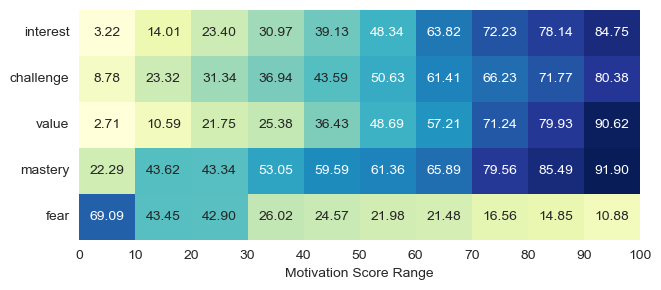

In [15]:
# create a heatmap of breakdown components for different ranges of motivation score
df['motivation_range'] = pd.cut(df[f'motivation--{model}--none'], bins=np.arange(0, 110, 10), right=False)
df_grouped = df.groupby('motivation_range').agg({f'{c}--{model}--none': 'mean' for c in cols if c != 'motivation'}).reset_index()
df_grouped = df_grouped.rename(columns={f'{c}--{model}--none': c for c in cols})
df_grouped = df_grouped.set_index('motivation_range')
plt.figure(figsize=(8, 3))
sns.heatmap(df_grouped.T, annot=True, fmt=".2f", cmap='YlGnBu')

plt.xticks(np.arange(0, 10.5, 1), 
           [f'{i*10}' for i in range(11)], 
           rotation=0, fontsize=10)

plt.xlabel('Motivation Score Range')
plt.yticks(rotation=0)
plt.grid(False)
# ignore the colorbar
cbar = plt.gcf().axes[-1]
cbar.set_visible(False)
plt.tight_layout()
# save_plot(f'pre_self_report_breakdown_by_motivation_score_range_{names[model]}')
plt.show()

Factor analysis of breakdown components

In [16]:
model = 'all'
model = model_name_clean(model)
df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))
breakdown_cols = ['value', 'challenge', 'fear', 'mastery', 'interest', 'motivation_score']
breakdown_cols = [f'{col}--{model}--{manip}' for col in breakdown_cols for manip in ['none']]
df = df.dropna(subset=breakdown_cols)
df = agg_remove_nans(df, breakdown_cols)[breakdown_cols]
df = df.rename(columns={col: col.split('--')[0] for col in breakdown_cols})

X = df.values[:, :-1]
y = df.values[:, -1]

# standardize the data
scaler = StandardScaler()
Z = scaler.fit_transform(X)

R = np.cov(Z, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(R)
idx = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
print("Eigenvalues:", eigvals)

Eigenvalues: [3.81157555 0.7685902  0.22917383 0.12688419 0.06761058]


In [17]:
k = 2  # set number of factors based on the analysis above
V = eigvecs[:, :k]
Lam = np.diag(np.sqrt(eigvals[:k]))

L = V @ Lam  # loadings (i.e., correlations between variables and factors); (d x k)
rotator = Rotator(method='varimax')
L_rot = rotator.fit_transform(L)
L_rot *= -1  # flip signs for easier interpretability

loading_df = pd.DataFrame(L_rot.T, index=[f'Factor {i+1}' for i in range(k)], columns=df.columns[:-1])
# loading_df.to_csv(f'tables/factor_analysis_{model}_loadings.csv')
loading_df.round(3)

,value,challenge,fear,mastery,interest
Factor 1,0.842,0.912,-0.303,0.335,0.911
Factor 2,0.395,0.294,-0.911,0.901,0.347


In [18]:
FZ = Z @ V  # factor scores per observation; (n x k)
rotation_matrix = np.linalg.lstsq(L, L_rot, rcond=None)[0]
FZ_rot = FZ @ rotation_matrix  # rotated factor scores

motivation_score = df['motivation_score'].values
motivation_score_z = (motivation_score - np.mean(motivation_score)) / np.std(motivation_score)  # standardize

f1, f2 = FZ_rot[:, 0], FZ_rot[:, 1]
X_reg = pd.DataFrame({'f1': f1,
                      'f2': f2, 
                      'f1*f2': f1 * f2
                      })
X_reg = sm.add_constant(X_reg)  # add intercept
reg_model = sm.OLS(motivation_score_z, X_reg).fit()

model_results = {
    'coefficients': reg_model.params.to_dict(),
    'p_values': reg_model.pvalues.to_dict(),
    'r_squared': reg_model.rsquared,
    'eigvals': eigvals.tolist(),
    'k': k,
}
# with open(f'results/factor_analysis_{model}_results.json', 'w') as f:    
#     json.dump(model_results, f, indent=4)
model_results

{'coefficients': {'const': 0.013529868549863903,
  'f1': 0.40316060679365867,
  'f2': 0.23632565700398853,
  'f1*f2': -0.009058984959819851},
 'p_values': {'const': 0.20656340224404302,
  'f1': 1.1212374292519908e-298,
  'f2': 2.8846893216287233e-77,
  'f1*f2': 0.004764617295697916},
 'r_squared': 0.8806578128191794,
 'eigvals': [3.8115755490641035,
  0.7685901994959872,
  0.22917382956837515,
  0.1268841927027158,
  0.06761058499704059],
 'k': 2}

In [19]:
factor_scores_df = pd.DataFrame(FZ_rot, columns=[f'Factor {i+1}' for i in range(k)])
factor_scores_df['motivation_score'] = motivation_score
corr_matrix = factor_scores_df.corr()
# compute p-values for the correlations

for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        if i < j:
            corr, p_value = pearsonr(factor_scores_df[col1], factor_scores_df[col2])
            if p_value > 0.01:
                print(f'WARNING: {names[model]}: {col1} <> {col2}: p-value: {p_value:.3f}')

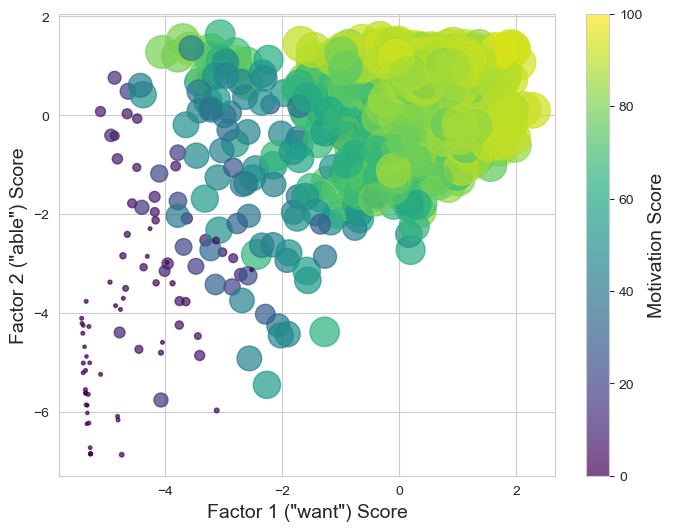

In [20]:
# scatter plot of factor scores colored by motivation score
df2 = df.copy()
plt.figure(figsize=(8, 6))
sc = plt.scatter(FZ_rot[:, 0], FZ_rot[:, 1], 
                 c=motivation_score, s=motivation_score*7, cmap='viridis', alpha=0.7, vmin=0, vmax=100)
cb = plt.colorbar(sc)
cb.set_label("Motivation Score", fontsize=14)

# increase font size
plt.xlabel('Factor 1 ("want") Score', fontsize=14) 
plt.ylabel('Factor 2 ("able") Score', fontsize=14)
plt.xticks(range(-4, 3, 2))
# save_plot(f'factor_analysis_scatter_{model}')
plt.show()